# Predicting Bike Rental Demand

Link to the data https://archive.ics.uci.edu/ml/machine-learning-databases/00275/. 
*Make sure to download and unzip the dataset into the same folder as this notebook*

This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information

**Data Set Information:**

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues.

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

In [1]:
# Import the necessary libraries

import numpy as np
import pandas as pd
import pandas_profiling as pp
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [2]:
# Improving visual appearance of graphs
sns.set(rc={'figure.figsize':(13, 10)})

# Ensure all columns are displayed
pd.pandas.set_option('display.max_columns', None)

In [3]:
# Load the data into a dataframe
# We use 'parse_dates' to convert the 'dteday' column into a 'datetime64[ns]' data type

df = pd.read_csv('hour.csv', parse_dates=['dteday'])
df.head()

instant     dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1 2011-01-01       1   0     1   0        0        6           0   
1        2 2011-01-01       1   0     1   1        0        6           0   
2        3 2011-01-01       1   0     1   2        0        6           0   
3        4 2011-01-01       1   0     1   3        0        6           0   
4        5 2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null datetime64[ns]
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(12)
memory usage: 2.3 MB


In [5]:
# Check for null values

df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [6]:
# Check for duplicated values

df.duplicated().sum()

0

# Data Analysis and Preparation

In [7]:
df.head()

instant     dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1 2011-01-01       1   0     1   0        0        6           0   
1        2 2011-01-01       1   0     1   1        0        6           0   
2        3 2011-01-01       1   0     1   2        0        6           0   
3        4 2011-01-01       1   0     1   3        0        6           0   
4        5 2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

**Attribute Information:**

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv

- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [8]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [9]:
df['season'].unique()

array([1, 2, 3, 4], dtype=int64)

In [10]:
df['yr'].unique()

array([0, 1], dtype=int64)

In [11]:
df['mnth'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [12]:
df['weekday'].unique()

array([6, 0, 1, 2, 3, 4, 5], dtype=int64)

In [13]:
df['weathersit'].unique()

array([1, 2, 3, 4], dtype=int64)

According to the attribute information above, some of the variables are categorical, even though they have been recorded as numbers. We can convert them into their correct categories as follows...

In [14]:
# season (1:winter, 2:spring, 3:summer, 4:fall)
df['season'] = df['season'].map({1:'Winter', 2:'Spring', 3:'Summer', 4:'Fall'})

# year (0: 2011, 1:2012)
df['yr'] = df['yr'].map({0: 2011, 1:2012})

# month ( 1 to 12)
df['mnth'] = df['mnth'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'June', 7:'July', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'})

# day of the week
df['weekday'] = df['weekday'].map({0:'Sunday', 1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday'})

# weather
df['weathersit'] = df['weathersit'].map({1:'Clear', 2:'Mist', 3:'Light Snow', 4:'Heavy Rain'})


In [15]:
df.sample(5)

instant     dteday  season    yr  mnth  hr  holiday    weekday  \
14761    14762 2012-09-12  Summer  2012  Sept   6        0  Wednesday   
9998      9999 2012-02-26  Winter  2012   Feb  15        0     Sunday   
12574    12575 2012-06-13  Spring  2012  June   3        0  Wednesday   
17185    17186 2012-12-23  Winter  2012   Dec  20        0     Sunday   
11747    11748 2012-05-09  Spring  2012   May  16        0  Wednesday   

       workingday weathersit  temp   atemp   hum  windspeed  casual  \
14761           1      Clear  0.50  0.4848  0.72     0.0896       6   
9998            0      Clear  0.36  0.3485  0.29     0.0000      72   
12574           1      Clear  0.62  0.5758  0.83     0.1940       1   
17185           0      Clear  0.26  0.3030  0.65     0.0000       0   
11747           1       Mist  0.66  0.6212  0.50     0.1940      68   

       registered  cnt  
14761         199  205  
9998          281  353  
12574           7    8  
17185          52   52  
11747         289  357

In [16]:
pp.ProfileReport(df)

In [17]:
# Dealing with highly correlated data. Delete atemp and registered

df.drop(['atemp','registered'],axis=1,inplace=True)

# Data Visualization

In [18]:
df.head()

instant     dteday  season    yr mnth  hr  holiday   weekday  workingday  \
0        1 2011-01-01  Winter  2011  Jan   0        0  Saturday           0   
1        2 2011-01-01  Winter  2011  Jan   1        0  Saturday           0   
2        3 2011-01-01  Winter  2011  Jan   2        0  Saturday           0   
3        4 2011-01-01  Winter  2011  Jan   3        0  Saturday           0   
4        5 2011-01-01  Winter  2011  Jan   4        0  Saturday           0   

  weathersit  temp   hum  windspeed  casual  cnt  
0      Clear  0.24  0.81        0.0       3   16  
1      Clear  0.22  0.80        0.0       8   40  
2      Clear  0.22  0.80        0.0       5   32  
3      Clear  0.24  0.75        0.0       3   13  
4      Clear  0.24  0.75        0.0       0    1

In [19]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'casual',
       'cnt'],
      dtype='object')

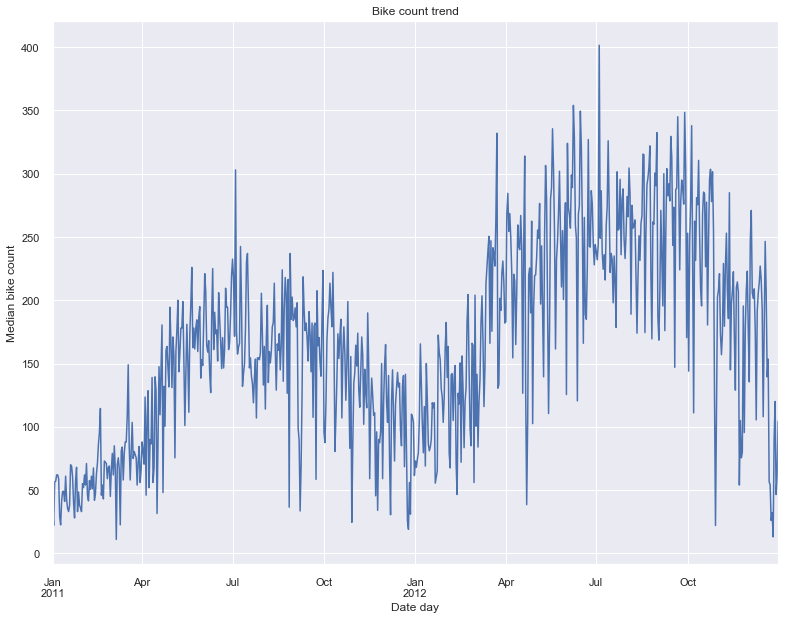

In [20]:
df.groupby('dteday')['cnt'].median().plot.line()
plt.xlabel('Date day')
plt.ylabel('Median bike count')
plt.title('Bike count trend')
plt.show()

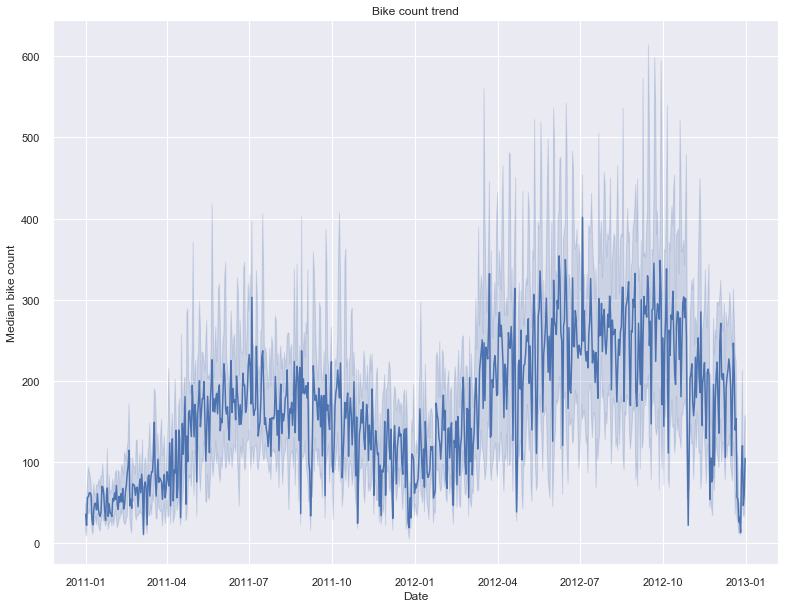

In [21]:
# Seaborn
ax = sns.lineplot(x='dteday', y='cnt', estimator=np.median, data=df)
ax.set(xlabel='Date',
       ylabel='Median bike count',
       title='Bike count trend')
plt.show()

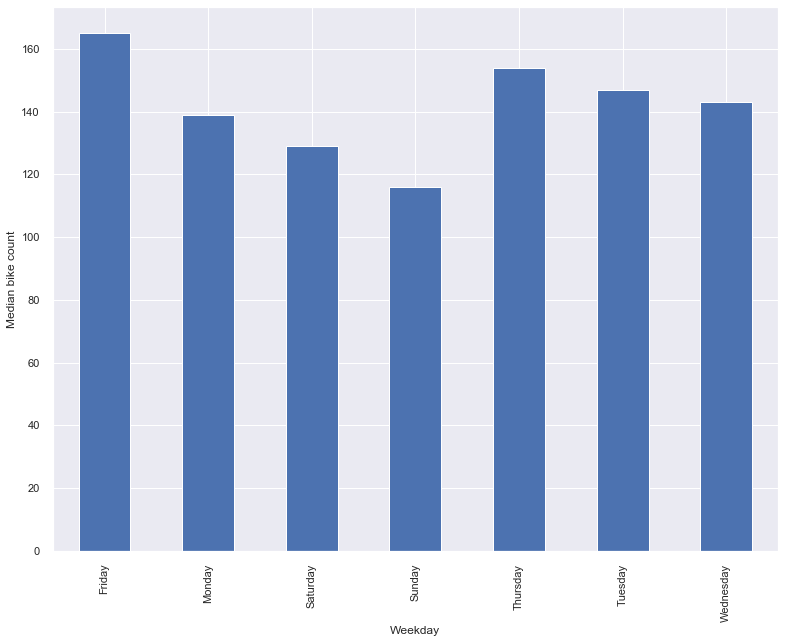

In [22]:
df.groupby('weekday')['cnt'].median().plot.bar()
plt.xlabel('Weekday')
plt.ylabel('Median bike count')
plt.show()

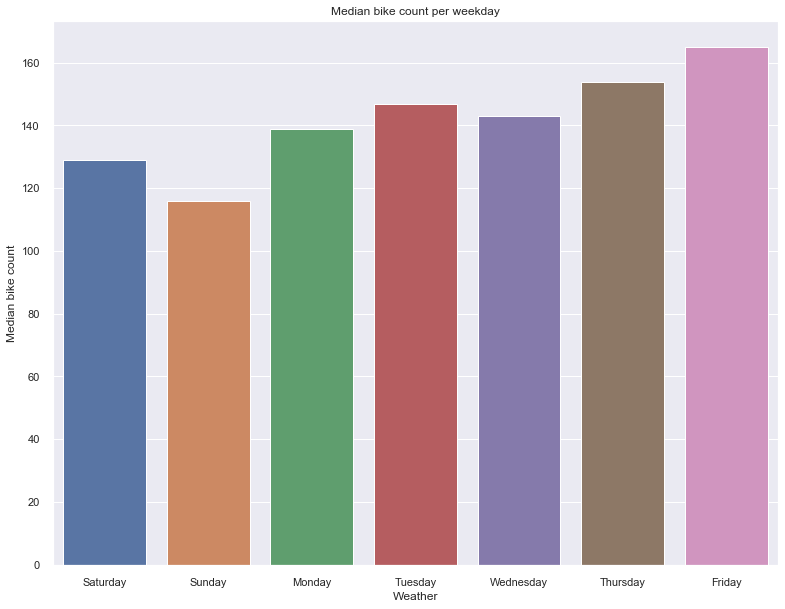

In [23]:
# Seaborn
ax = sns.barplot(x = 'weekday', y = 'cnt', data=df, ci=None, estimator=np.median)
ax.set(xlabel='Weather',
       ylabel='Median bike count',
       title='Median bike count per weekday')
plt.show()

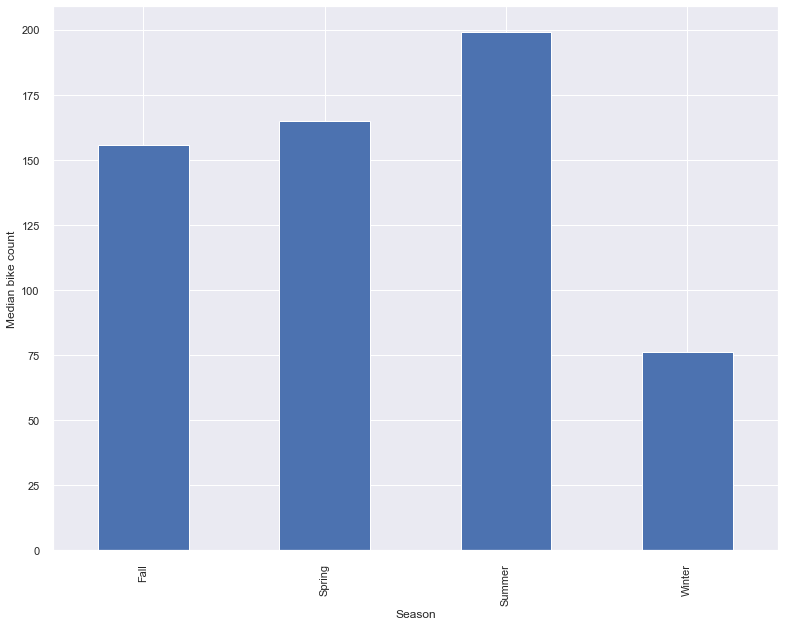

In [24]:
df.groupby('season')['cnt'].median().plot.bar()
plt.xlabel('Season')
plt.ylabel('Median bike count')
plt.show()

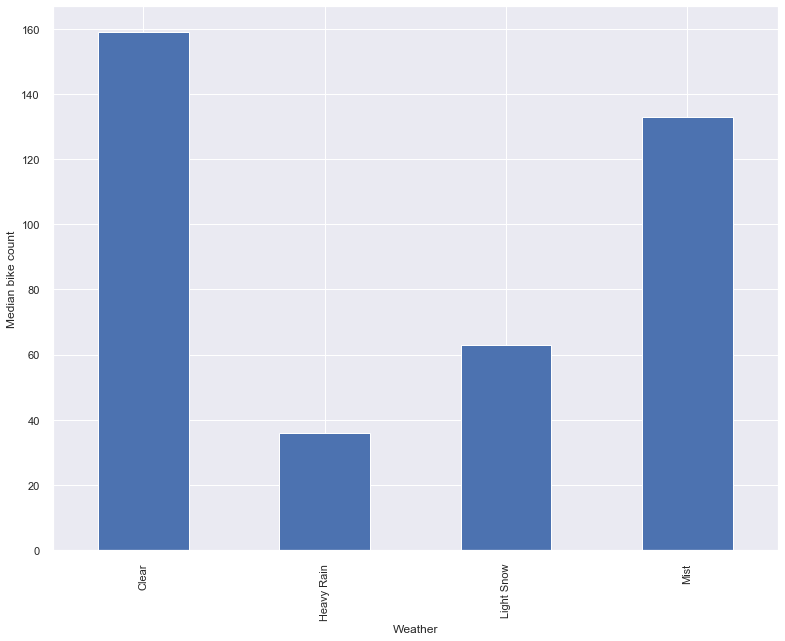

In [25]:
df.groupby('weathersit')['cnt'].median().plot.bar()
plt.xlabel('Weather')
plt.ylabel('Median bike count')
plt.show()

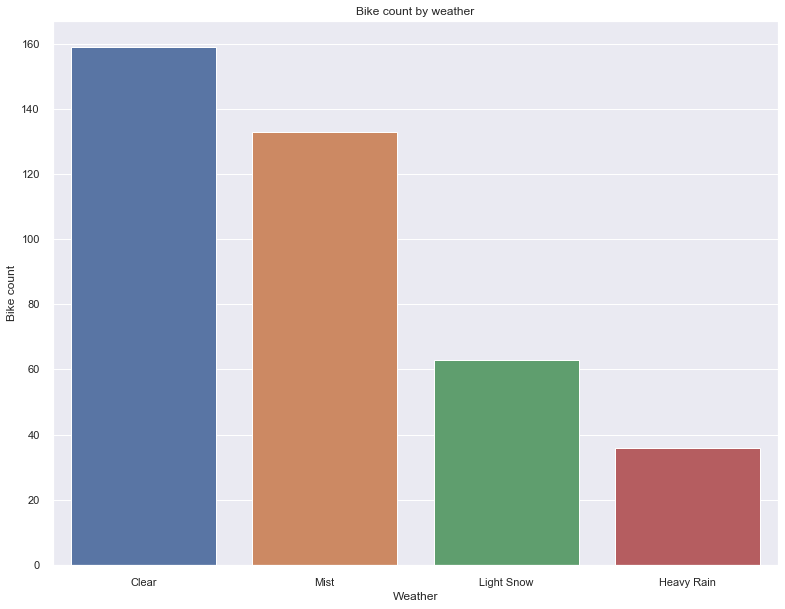

In [26]:
ax = sns.barplot(x = 'weathersit', y = 'cnt', data=df, estimator=np.median, ci=None)
ax.set(xlabel='Weather',
       ylabel='Bike count',
       title='Bike count by weather')
plt.show()

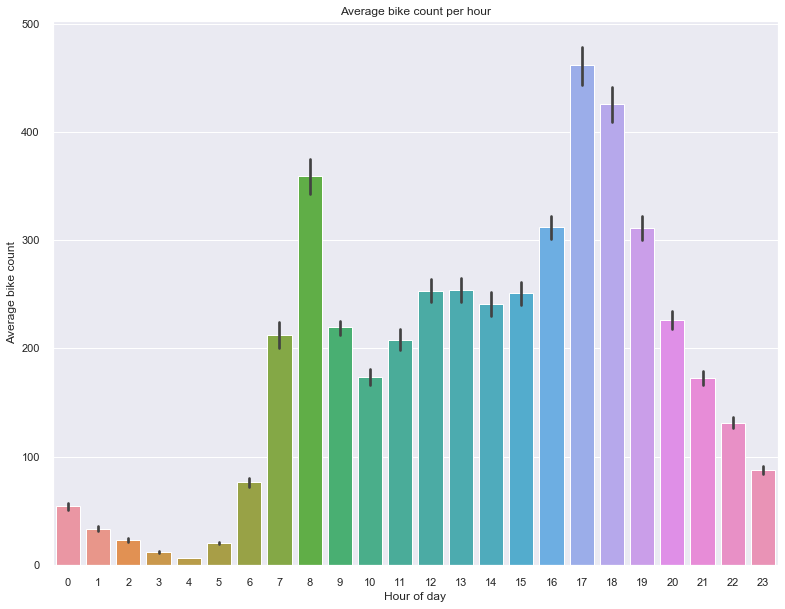

In [27]:
ax = sns.barplot(x='hr', y='cnt', data=df)
ax.set(xlabel='Hour of day',
       ylabel='Average bike count',
       title='Average bike count per hour')
plt.show()

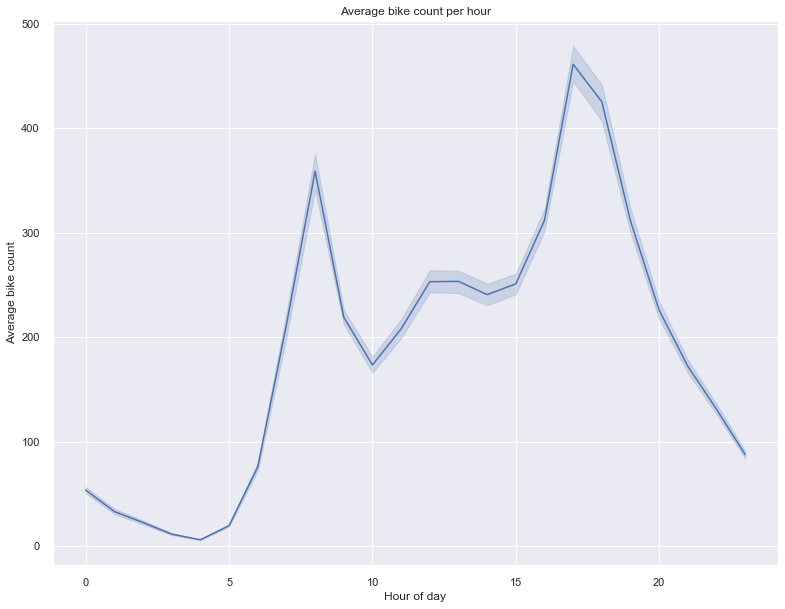

In [28]:
ax = sns.lineplot(x='hr', y='cnt', data=df)
ax.set(xlabel='Hour of day',
       ylabel='Average bike count',
       title='Average bike count per hour')
plt.show()

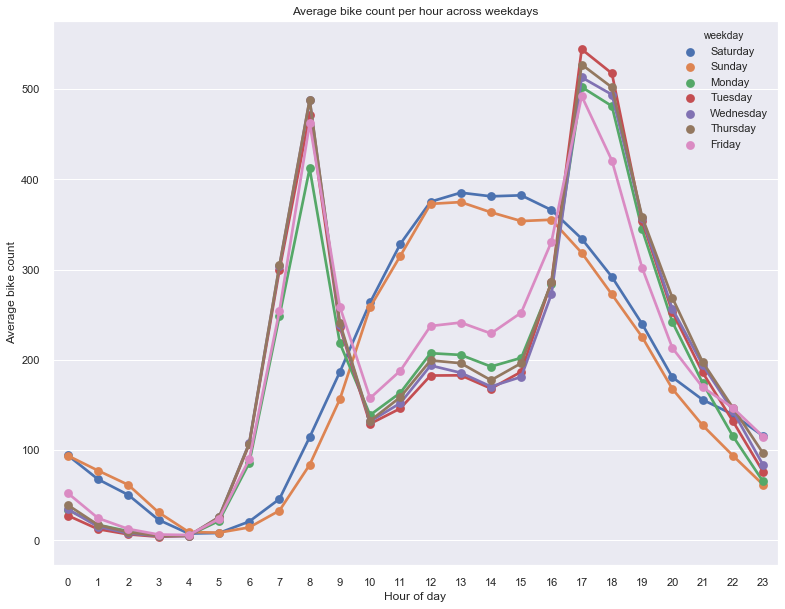

In [29]:
ax = sns.pointplot(x='hr', y='cnt', hue='weekday', ci=None, data=df)
ax.set(xlabel='Hour of day',
       ylabel='Average bike count',
       title='Average bike count per hour across weekdays')
plt.show()

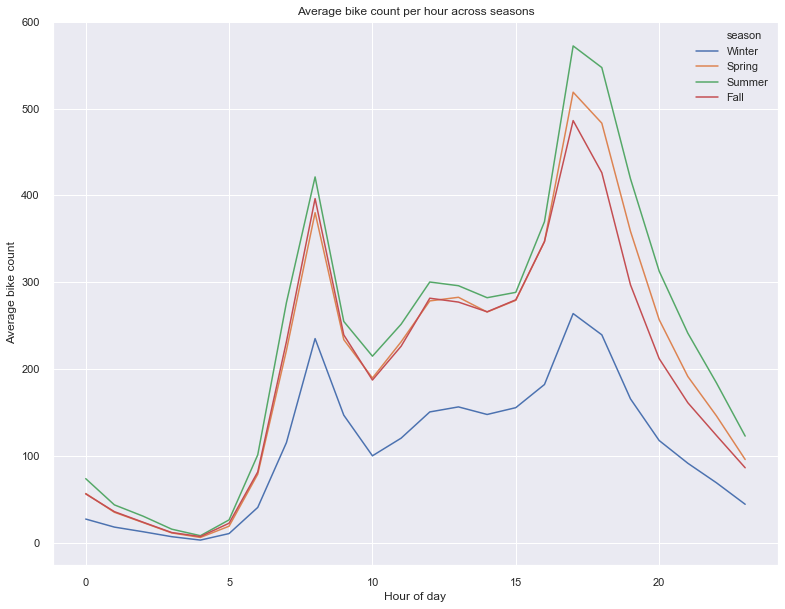

In [30]:
ax = sns.lineplot(x='hr', y='cnt', hue='season', ci=None, data=df)
ax.set(xlabel='Hour of day',
       ylabel='Average bike count',
       title='Average bike count per hour across seasons')
plt.show()

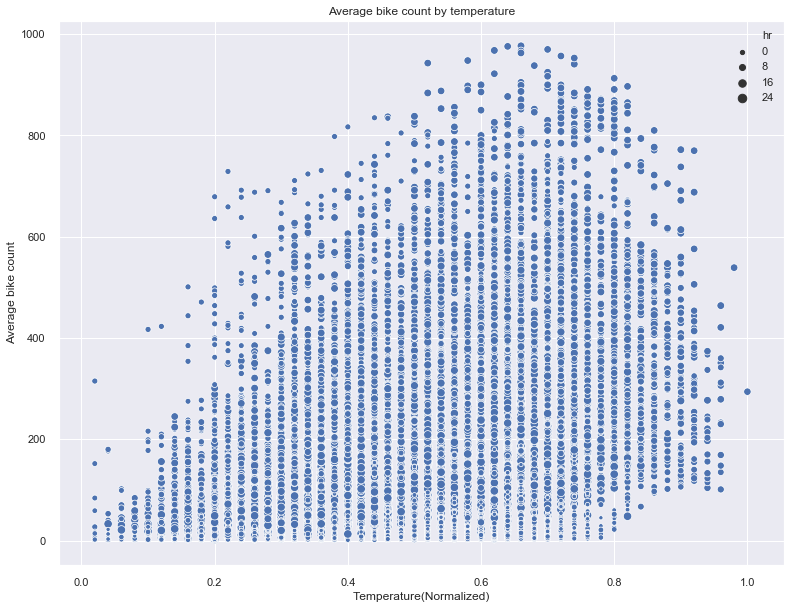

In [31]:
ax = sns.scatterplot(x='temp', y='cnt', size='hr', ci=None, data=df)
ax.set(xlabel='Temperature(Normalized)',
       ylabel='Average bike count',
       title='Average bike count by temperature')
plt.show()

# Feature Engineering

In [32]:
# function to extract the day from the dteday column
# we won't extract year and month since we have them already as columns

def extract_date(df, column):
    df[column+"_day"] = df[column].apply(lambda x: x.day)
    #df[column+"_month"] = df[column].apply(lambda x: x.month)
    #df[column+"_year"] = df[column].apply(lambda x: x.year)
    
extract_date(df, 'dteday')
df.head()

instant     dteday  season    yr mnth  hr  holiday   weekday  workingday  \
0        1 2011-01-01  Winter  2011  Jan   0        0  Saturday           0   
1        2 2011-01-01  Winter  2011  Jan   1        0  Saturday           0   
2        3 2011-01-01  Winter  2011  Jan   2        0  Saturday           0   
3        4 2011-01-01  Winter  2011  Jan   3        0  Saturday           0   
4        5 2011-01-01  Winter  2011  Jan   4        0  Saturday           0   

  weathersit  temp   hum  windspeed  casual  cnt  dteday_day  
0      Clear  0.24  0.81        0.0       3   16           1  
1      Clear  0.22  0.80        0.0       8   40           1  
2      Clear  0.22  0.80        0.0       5   32           1  
3      Clear  0.24  0.75        0.0       3   13           1  
4      Clear  0.24  0.75        0.0       0    1           1

In [33]:
# Specify categorical columns then convert them into numerical variables using one hot encoding

cat_cols = ['season', 'mnth', 'weekday', 'weathersit']

df = pd.get_dummies(df, columns=cat_cols)
df.shape

(17379, 39)

# Feature Selection

In [34]:
df.head()

instant     dteday    yr  hr  holiday  workingday  temp   hum  windspeed  \
0        1 2011-01-01  2011   0        0           0  0.24  0.81        0.0   
1        2 2011-01-01  2011   1        0           0  0.22  0.80        0.0   
2        3 2011-01-01  2011   2        0           0  0.22  0.80        0.0   
3        4 2011-01-01  2011   3        0           0  0.24  0.75        0.0   
4        5 2011-01-01  2011   4        0           0  0.24  0.75        0.0   

   casual  cnt  dteday_day  season_Fall  season_Spring  season_Summer  \
0       3   16           1            0              0              0   
1       8   40           1            0              0              0   
2       5   32           1            0              0              0   
3       3   13           1            0              0              0   
4       0    1           1            0              0              0   

   season_Winter  mnth_Apr  mnth_Aug  mnth_Dec  mnth_Feb  mnth_Jan  mnth_July  \
0              1         0         0         0         0         1          0   
1              1         0         0         0         0         1          0   
2              1         0         0         0         0         1          0   
3              1         0         0         0         0         1          0   
4              1         0         0         0         0         1          0   

   mnth_June  mnth_Mar  mnth_May  mnth_Nov  mnth_Oct  mnth_Sept  \
0          0         0         0         0         0          0   
1          0         0         0         0         0          0   
2          0         0         0         0         0          0   
3          0         0         0         0         0          0   
4          0         0         0         0         0          0   

   weekday_Friday  weekday_Monday  weekday_Saturday  weekday_Sunday  \
0               0               0                 1               0   
1               0               0                 1               0   
2               0               0                 1               0   
3               0               0                 1               0   
4               0               0                 1               0   

   weekday_Thursday  weekday_Tuesday  weekday_Wednesday  weathersit_Clear  \
0                 0                0                  0                 1   
1                 0                0                  0                 1   
2                 0                0                  0                 1   
3                 0                0                  0                 1   
4                 0                0                  0                 1   

   weathersit_Heavy Rain  weathersit_Light Snow  weathersit_Mist  
0                      0                      0                0  
1                      0                      0                0  
2                      0                      0                0  
3                      0                      0                0  
4                      0                      0                0

You should notice that the **cnt** column is a sum of the **casual + registered** columns. So we'll ignore the two columns during *feature selection* inorder to remove bias from our data.

We'll also ignore the **dteday** column since we have already extracted what we need from it

**instant** will also be ignored

In [35]:
df.columns

Index(['instant', 'dteday', 'yr', 'hr', 'holiday', 'workingday', 'temp', 'hum',
       'windspeed', 'casual', 'cnt', 'dteday_day', 'season_Fall',
       'season_Spring', 'season_Summer', 'season_Winter', 'mnth_Apr',
       'mnth_Aug', 'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_July',
       'mnth_June', 'mnth_Mar', 'mnth_May', 'mnth_Nov', 'mnth_Oct',
       'mnth_Sept', 'weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'weathersit_Clear', 'weathersit_Heavy Rain',
       'weathersit_Light Snow', 'weathersit_Mist'],
      dtype='object')

In [36]:
ignored_cols = ['casual', 'instant', 'dteday', 'cnt']

In [37]:
# specifying our features and target

x = df.drop(columns=ignored_cols)

y = df['cnt']

# Model Development

Always make several models so as to choose the best one

In [38]:
# Divide our dataset into training and testing set

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                   test_size=0.2,
                                                   random_state=7)

x_train.shape, x_test.shape

((13903, 35), (3476, 35))

In [39]:
# Linear Regression Algorithm

lr = LinearRegression()

# train model
lr.fit(x_train, y_train)

# use trained model to make predictions on x_test
y_pred_lr = lr.predict(x_test)

**Evaluation Metrics in Regression**
- https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4
- https://medium.com/acing-ai/how-to-evaluate-regression-models-d183b4f5853d

In [40]:
lr_mae = metrics.mean_absolute_error(y_test, y_pred_lr) # Mean Absolute Error
lr_mse = metrics.mean_squared_error(y_test, y_pred_lr) #Mean Squared error
lr_rmse = np.sqrt(metrics.mean_absolute_error(y_test, y_pred_lr))
lr_r2 = metrics.r2_score(y_test, y_pred_lr)

print('Linear Regression')
print('Mean Absolute Error', lr_mae)
print('Mean Squared Error', lr_mse)
print('Root Mean Squared Error',lr_rmse)
print('R2 Score',lr_r2)

Linear Regression
Mean Absolute Error 105.04097812195467
Mean Squared Error 19772.158294044733
Root Mean Squared Error 10.248950098520076
R2 Score 0.3952226634031486


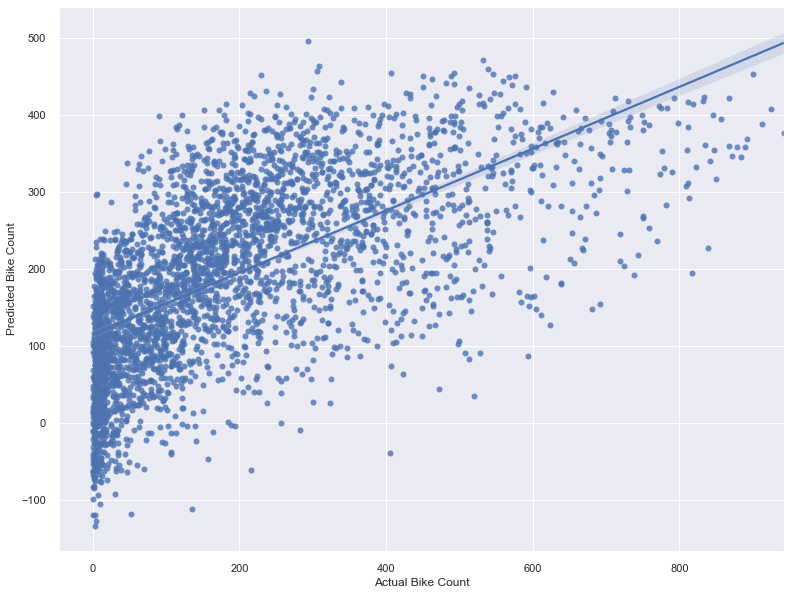

In [41]:
ax = sns.regplot(x = y_test, y = y_pred_lr)
ax.set(xlabel = 'Actual Bike Count',
      ylabel = 'Predicted Bike Count')
plt.show()

In [42]:
# Decision Tree Algorithm

dt = DecisionTreeRegressor()

# train model
dt.fit(x_train, y_train)

# use trained model to make predictions on x_test
y_pred_dt = dt.predict(x_test)

In [43]:
dt_mae = metrics.mean_absolute_error(y_test, y_pred_dt)
dt_mse = metrics.mean_squared_error(y_test, y_pred_dt)
dt_rmse = np.sqrt(metrics.mean_absolute_error(y_test, y_pred_dt))
dt_r2 = metrics.r2_score(y_test, y_pred_dt)

print('Decision Tree')
print('Mean Absolute Error', dt_mae)
print('Mean Squared Error', dt_mse)
print('Root Mean Squared Error',dt_rmse)
print('R2 Score',dt_r2)

Decision Tree
Mean Absolute Error 34.361047180667434
Mean Squared Error 3395.5727848101264
Root Mean Squared Error 5.861829678578816
R2 Score 0.8961385280009242


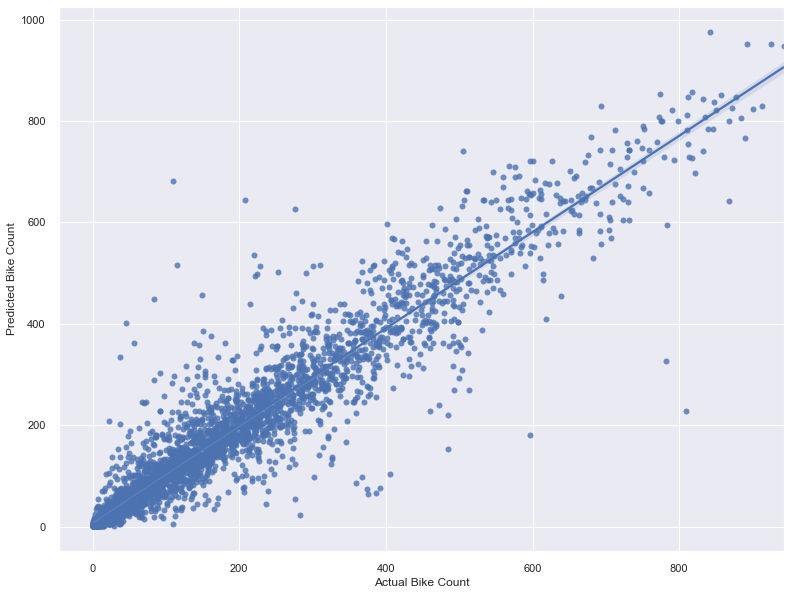

In [44]:
ax = sns.regplot(x = y_test, y = y_pred_dt)
ax.set(xlabel = 'Actual Bike Count',
      ylabel = 'Predicted Bike Count')
plt.show()

In [45]:
# K Nearest neighbor. You call it, train the model then predict

knn = KNeighborsRegressor(n_neighbors = 4)

#Train the thing

knn.fit(x_train,y_train)

#Let's Predict

y_pred_knn = knn.predict(x_test)



In [46]:
knn_mae = metrics.mean_absolute_error(y_test, y_pred_knn)
knn_mse = metrics.mean_squared_error(y_test,y_pred_knn)
knn_rmse = np.sqrt(metrics.mean_absolute_error(y_test, y_pred_knn))
knn_r2 = metrics.r2_score(y_test, y_pred_knn)

print('Decision Tree')
print('Mean Absolute Error', knn_mae)
print('Mean Squared Error', knn_mse)
print('Root Mean Squared Error',knn_rmse)
print('R2 Score',knn_r2)

Decision Tree
Mean Absolute Error 44.811421173762945
Mean Squared Error 4950.117448216341
Root Mean Squared Error 6.6941333400047345
R2 Score 0.8485891726309124


[0.7078794679432704, 0.861267669647313, 0.8646384856566781, 0.8485891726309124, 0.8403920993079709, 0.829999519550825, 0.8273769720777662, 0.8246395257233887, 0.819480452972646, 0.8136926793575145, 0.8100900472304458, 0.8045779133606157, 0.8021057780330891, 0.7977132858673298, 0.7953913502928031, 0.7916237558771508, 0.7890608647660491, 0.7875665223806404, 0.7859536930165217, 0.7836905035118449]


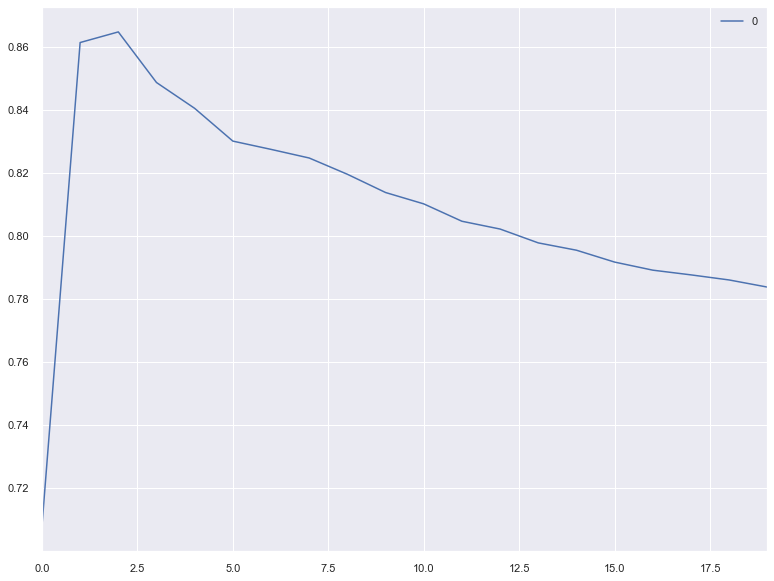

In [47]:
#To identify the best number of trees
r2_values=[]

for k in range(20):
    k+=1
    model = KNeighborsRegressor(n_neighbors = k)
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    r2 = metrics.r2_score(y_test,pred)
    r2_values.append(r2)
    
print (r2_values)

pd.DataFrame(r2_values).plot()

# Best value of K is 2

In [48]:
r2_values.sort()
print(r2_values)    

[0.7078794679432704, 0.7836905035118449, 0.7859536930165217, 0.7875665223806404, 0.7890608647660491, 0.7916237558771508, 0.7953913502928031, 0.7977132858673298, 0.8021057780330891, 0.8045779133606157, 0.8100900472304458, 0.8136926793575145, 0.819480452972646, 0.8246395257233887, 0.8273769720777662, 0.829999519550825, 0.8403920993079709, 0.8485891726309124, 0.861267669647313, 0.8646384856566781]


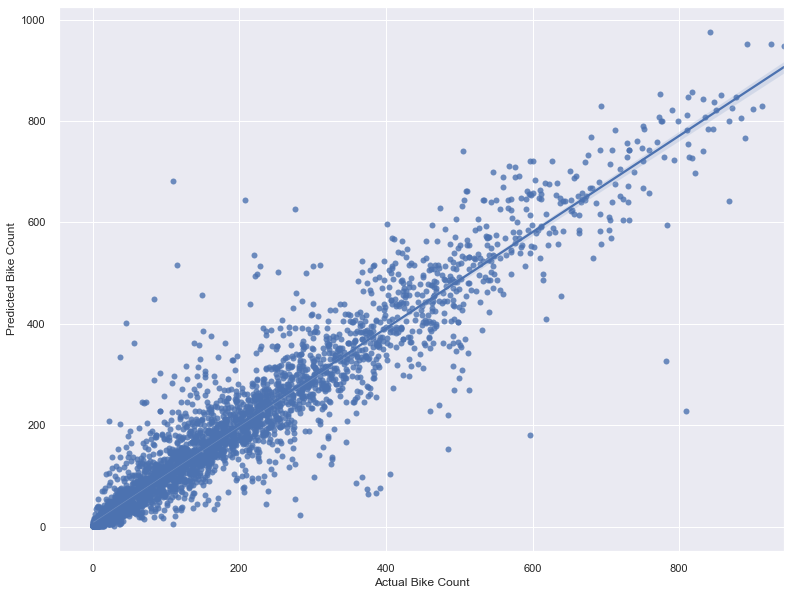

In [49]:
vx = sns.regplot(x = y_test, y = y_pred_dt)
vx.set(xlabel = 'Actual Bike Count',
      ylabel = 'Predicted Bike Count')
plt.show()

In [50]:
# Random forest

rf = RandomForestRegressor(n_estimators = 100)

#Train the model

rf.fit(x_train,y_train)

# Predict

y_pred_rf = rf.predict(x_test)

In [51]:
rf_mae = metrics.mean_absolute_error(y_test,y_pred_rf)

rf_mse = metrics.mean_squared_error(y_test,y_pred_rf)

rf_rmse = np.sqrt(rf_mse)

rf_r2 = metrics.r2_score(y_test, y_pred_rf)

print ('Random Forest Analysis')
print('Mean Absolute Error;',rf_mae)
print('Mean Squared Error;', rf_mse)
print('Root Mean Squared Error;', rf_rmse)
print('R2;', rf_r2)

Random Forest Analysis
Mean Absolute Error; 25.10077675489068
Mean Squared Error; 1803.9878448216339
Root Mean Squared Error; 42.47337807170079
R2; 0.9448208461707022


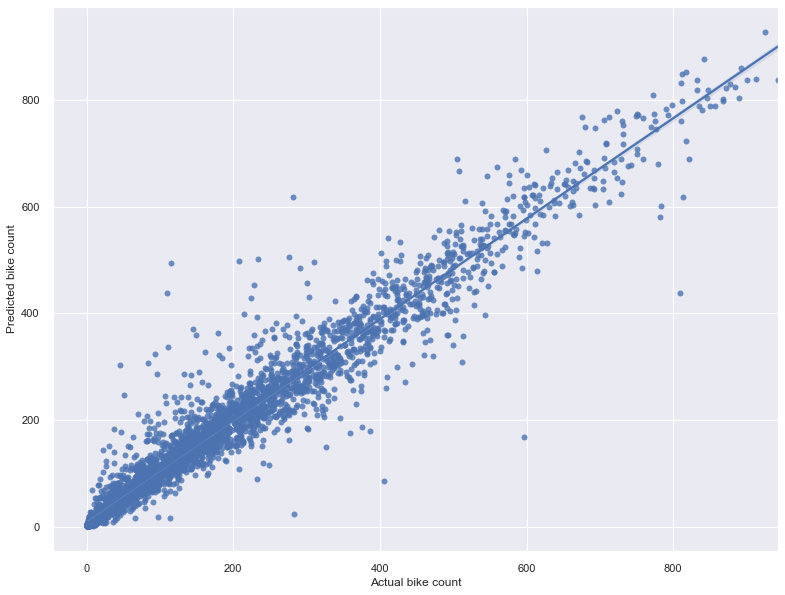

In [52]:
rx = sns.regplot(x=y_test, y = y_pred_rf)

rx.set(xlabel = 'Actual bike count',
       ylabel = 'Predicted bike count')
plt.show()